In [1]:
import whale_wallet as ww
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# Função para coletar dados históricos para uma lista de tickers
def coletar_dados(tickers, period):
    dados = {}  # Dicionário para armazenar os dados de cada ticker
    for ticker in tickers:
        try:
            # Coletar dados históricos para o ticker atual
            ticker_symbol = ticker
            dados[ticker] = ww.ydata(ticker_symbol, period=period).get_stock_data()
            #print(f"Dados coletados para {ticker}")
        except Exception as e:
            print(f"Erro ao coletar dados para {ticker}: {str(e)}")
    return dados

def add_sa_to_tickers(tickers):
    return [ticker + '.SA' for ticker in tickers]

# Function to calculate simple and log returns
def calculate_returns(df):
    df['Simple Return'] = df['Fechamento'].pct_change() * 100
    df['Log Return'] = np.log(df['Fechamento'] / df['Fechamento'].shift(1)) * 100
    return df


def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_returns_df.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_returns_df.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# Inputs

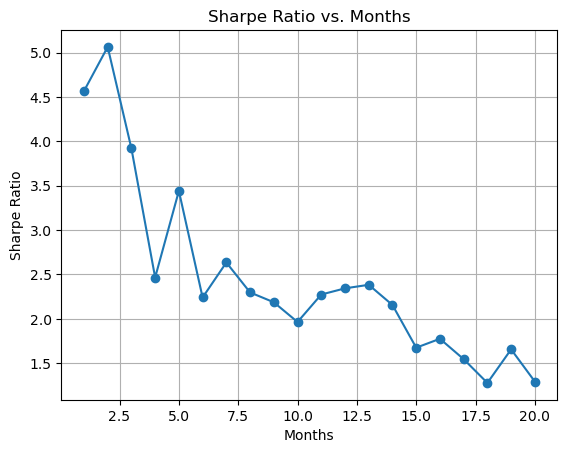

In [3]:
ticker_symbols =  ['CYRE3', 'B3SA3', 'VALE3', 'VBBR3','CMIG4','CPLE6','BBSE3','EGIE3','JBSS3','KLBN11']
#benchmark = 'BOVA11'
# Define lists to store months and corresponding Sharpe Ratios
months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


sharpe_ratios = []

# Create an empty DataFrame with MultiIndex
index = pd.MultiIndex.from_product([months_list, ticker_symbols], names=['Months', 'Ticker'])
results_df = pd.DataFrame(index=index, columns=['Return', 'Volatility', 'Sharpe Ratio', 'Allocation'])

for months in months_list:
    trading_days = 21 * months  # Calculate trading days for each month
    period = str(trading_days) + 'd'
    # Collecting data
    all_data = coletar_dados(ticker_symbols, period=period)
    # Iterate over each item in the dictionary
    for stock, data in all_data.items():
        all_data[stock] = calculate_returns(data)

    # Extract and concatenate log returns from each all_data DataFrame
    log_returns_df = pd.concat([data['Log Return'] for stock, data in all_data.items()], axis=1)
    log_returns_df.columns = all_data.keys()  # Assign stock symbols as column names
    log_returns_df = log_returns_df.dropna() / 100

    # Determine the number of columns (stocks) in log_returns_df
    num_stocks = len(log_returns_df.columns)
    # Create Random Weights
    weights = np.array(np.random.random(num_stocks))
    # Rebalance Weights
    weights = weights / np.sum(weights)

    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type': 'eq', 'fun': check_sum})
    # Create bounds for each weight
    bounds = [(0, 1) for _ in range(num_stocks)]
    # Initial Guess (equal distribution)
    init_guess = [1 / num_stocks for _ in range(num_stocks)]
    # Sequential Least SQuares Programming (SLSQP).
    opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    opt_weights = opt_results.x

    # Total portfolio value (e.g., your initial investment amount)
    portfolio_value = 1  # Replace with your desired amount
    # Calculate the allocation for each stock
    stock_allocations = opt_weights * portfolio_value
    # Create a DataFrame to represent the portfolio
    portfolio = pd.DataFrame({'Stock': log_returns_df.columns, 'Allocation': stock_allocations})
    # Threshold for dropping stocks
    threshold = 1.0e-03
    # Format and filter the portfolio DataFrame
    portfolio['Allocation'] = portfolio['Allocation'].apply(lambda x: round(x, 4))
    portfolio = portfolio[portfolio['Allocation'] > threshold]
    
    # Store Allocation in results_df
    for ticker in portfolio['Stock']:
        results_df.loc[(months, ticker), 'Allocation'] = portfolio.loc[portfolio['Stock'] == ticker, 'Allocation'].values[0]

    # Calculate the sum of the 'Allocation' column must be equal to 100%
    total_allocation = portfolio['Allocation'].sum()

    result_array = get_ret_vol_sr(opt_weights)
    # Extract individual values
    return_value = result_array[0]
    volatility_value = result_array[1]
    sharpe_ratio = result_array[2]

    # Store results in the DataFrame
    for ticker in portfolio['Stock']:
        results_df.loc[(months, ticker), ['Return', 'Volatility', 'Sharpe Ratio']] = [return_value, volatility_value, sharpe_ratio]

    # Get Sharpe Ratio
    sharpe_ratios.append(sharpe_ratio)

# Plotting
plt.plot(months_list, sharpe_ratios, marker='o')
plt.title('Sharpe Ratio vs. Months')
plt.xlabel('Months')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

# Display the results DataFrame
results_df = results_df.dropna()



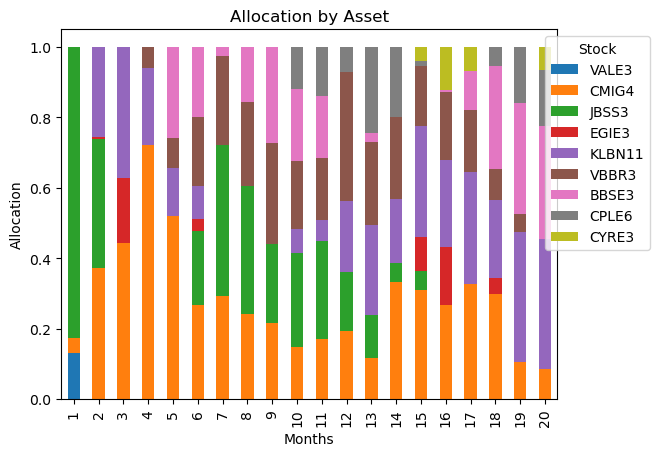

In [5]:
# Extracting the allocation values for each ticker
allocation_df = results_df['Allocation'].unstack()

# Plotting
allocation_df.plot(kind='bar', stacked=True)
plt.title('Allocation by Asset')
plt.xlabel('Months')
plt.ylabel('Allocation')
plt.legend(title='Stock', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


In [6]:
# Filter the DataFrame for the month equal to 9
selected_month = 9
allocation_month = results_df.loc[selected_month]

# Print the allocation values
print(f"Allocation for Month {selected_month}:")
print(allocation_month)

Allocation for Month 9:
          Return Volatility Sharpe Ratio Allocation
Ticker                                             
VBBR3   0.323688   0.147999     2.187091     0.2884
CMIG4   0.323688   0.147999     2.187091     0.2167
BBSE3   0.323688   0.147999     2.187091     0.2725
JBSS3   0.323688   0.147999     2.187091     0.2224


## BulletShape For Original Selection

In [7]:
# Selecting a given month
months = 9

In [8]:
trading_days = 21*months # 3 months worth of data
period = str(trading_days) + 'd'
# colecting data
all_data = coletar_dados(ticker_symbols, period = period)
# Iterate over each item in the dictionary
for stock, data in all_data.items():
    all_data[stock] = calculate_returns(data)
    
# Extract and concatenate log returns from each all_data DataFrame
log_returns_df = pd.concat([data['Log Return'] for stock, data in all_data.items()], axis=1)
log_returns_df.columns = all_data.keys()  # Assign stock symbols as column names
log_returns_df = log_returns_df.dropna() / 100

# Extrating closing prices from all_data dict.
price_df = pd.concat([data['Fechamento'] for stock, data in all_data.items()], axis=1)
price_df.columns = all_data.keys()  # Assign stock symbols as column names

TOP sharpe =  1.850443343764679


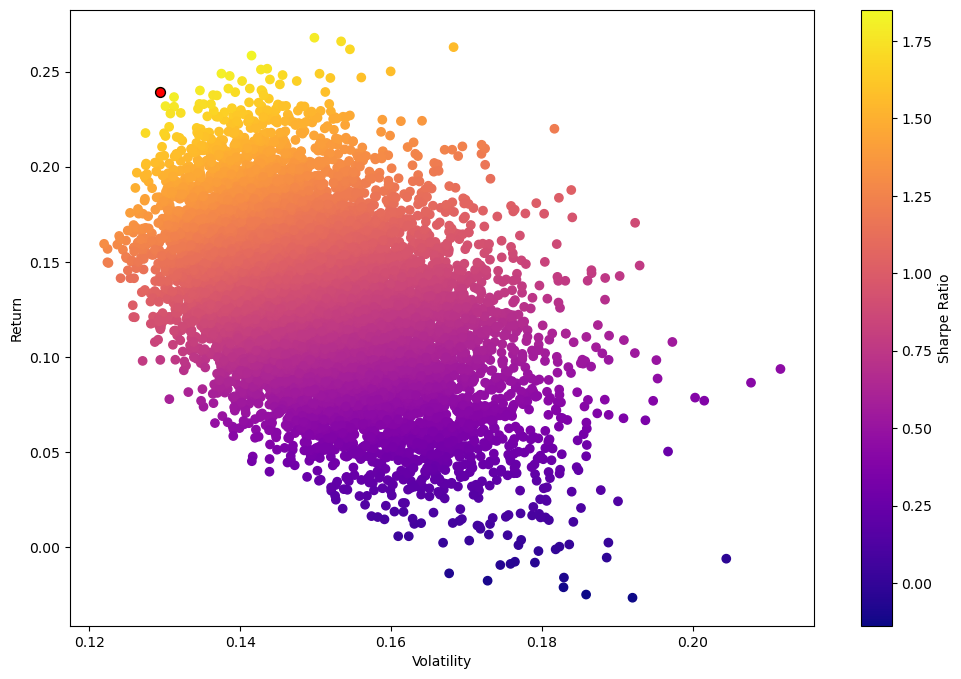

In [9]:
# Selecting from Original Selection
selected_returns_df = log_returns_df.copy()

# Now, 'selected_returns_df' contains only the columns specified in 'portfolio'

num_ports = 10000

all_weights = np.zeros((num_ports, len(selected_returns_df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    # Create Random Weights
    weights = np.array(np.random.random(len(selected_returns_df.columns)))

    # Rebalance Weights
    weights = weights / np.sum(weights)

    # Save Weights
    all_weights[ind, :] = weights

    # Expected Return
    ret_arr[ind] = np.sum((selected_returns_df.mean() * weights) * 252)

    # Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_returns_df.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
    
found = int(sharpe_arr.argmax())
max_sr_ret = ret_arr[found]
max_sr_vol = vol_arr[found]
#all_weights[found,:] # shows the weights allocated for this simulation
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
print('TOP sharpe = ',sharpe_arr.max())

# BulletShape for Optimal Selection

In [10]:
# Selecting from Optimal Solution.
selected_stocks = allocation_month.index.tolist()
# Create a new DataFrame with selected columns
selected_returns_df = log_returns_df[selected_stocks]

TOP sharpe =  2.186848479315699
Return: 32.19%
Volatility: 14.72%
Sharpe Ratio: 2.19


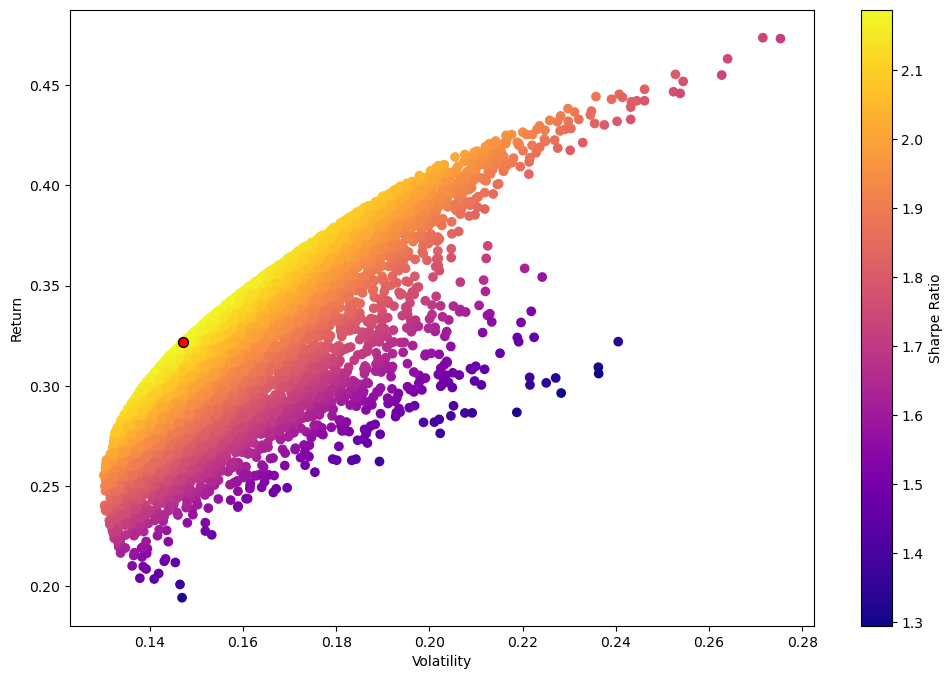

In [11]:
num_ports = 10000

all_weights = np.zeros((num_ports, len(selected_returns_df.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    # Create Random Weights
    weights = np.array(np.random.random(len(selected_returns_df.columns)))

    # Rebalance Weights
    weights = weights / np.sum(weights)

    # Save Weights
    all_weights[ind, :] = weights

    # Expected Return
    ret_arr[ind] = np.sum((selected_returns_df.mean() * weights) * 252)

    # Expected Volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(selected_returns_df.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]
    
found = int(sharpe_arr.argmax())
max_sr_ret = ret_arr[found]
max_sr_vol = vol_arr[found]
#all_weights[found,:] # shows the weights allocated for this simulation
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')
print('TOP sharpe = ',sharpe_arr.max())
# Print the results
print(f"Return: {max_sr_ret:.2%}")
print(f"Volatility: {max_sr_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_arr.max():.2f}")

# Plotting the results

In [19]:
# Selecting from Optimal Solution.
selected_stocks = allocation_month.index.tolist()
trading_days = 21*months # 3 months worth of data
period = str(trading_days) + 'd'
# colecting data
all_data = coletar_dados(selected_stocks, period = period)
# Iterate over each item in the dictionary
for stock, data in all_data.items():
    all_data[stock] = calculate_returns(data)    
# Extract and concatenate log returns from each all_data DataFrame
log_returns_df = pd.concat([data['Log Return'] for stock, data in all_data.items()], axis=1)
log_returns_df.columns = all_data.keys()  # Assign stock symbols as column names
log_returns_df = log_returns_df.dropna() / 100
# Extrating closing prices from all_data dict.
price_df = pd.concat([data['Fechamento'] for stock, data in all_data.items()], axis=1)
price_df.columns = all_data.keys()  # Assign stock symbols as column names
# Create a dictionary to map tickers to allocation values
allocation_dict = allocation_month['Allocation'].to_dict()
# Calculate the total allocation for each row in price_df
total_allocation = price_df.apply(lambda row: sum(row[ticker] * allocation_dict[ticker] for ticker in price_df.columns), axis=1)
# Add the 'Total_Allocation' column to price_df
price_df['Total_Allocation'] = total_allocation

### Portfolio Performance

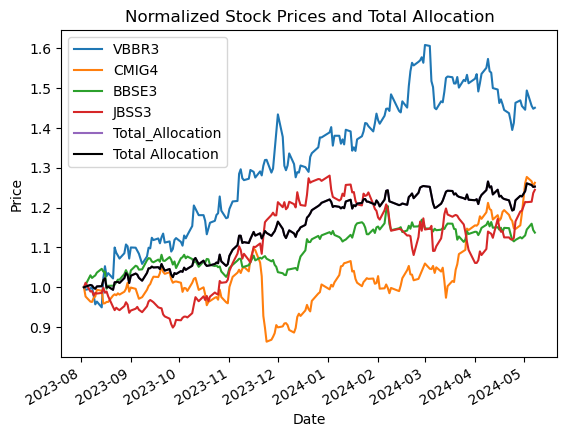

In [21]:
stock_normed = price_df/price_df.iloc[0]
# Plotting the normalized stock prices
stock_normed.plot()
# Plotting the 'Total_Allocation' column in black
plt.plot(stock_normed.index, stock_normed['Total_Allocation'], color='black', label='Total Allocation')
# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Normalized Stock Prices and Total Allocation')
plt.legend()
# Display the plot
plt.show()